<a href="https://colab.research.google.com/github/fajrunwm/gisml/blob/main/Agriculture_Augmentation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agriculture Augmentation

In [1]:
# Mounting Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Phase 3: Model Building/Development

## Data Preparation

In [2]:
!pip install rasterio tifftools -q

In [3]:
# Import Essential Libraries
import os # Operating system interfaces for file handling
import numpy as np  # Numerical operations on large arrays
import tensorflow as tf  # TensorFlow for deep learning
import matplotlib.pyplot as plt  # Plotting and visualisation
import time  # Time-related functions
import seaborn as sns  # Advanced statistical visualisation

from osgeo import gdal
from collections import defaultdict  # Dictionary with default values
from PIL import Image  # Image processing library
from sklearn.metrics import confusion_matrix  # Confusion matrix for evaluation
from sklearn.model_selection import train_test_split  # Splitting the dataset into training and validation sets
from tensorflow.keras.utils import to_categorical  # Convert class vectors to binary class matrices
from tensorflow.keras.utils import plot_model # For plotting the model
from tensorflow.keras.utils import img_to_array  # Convert an image to a numpy array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate  # Layers for building the U-Net model
from tensorflow.keras.models import Model, load_model  # Class to create a Keras model
from tensorflow.keras.optimizers import Adam  # Adam optimizer
from tensorflow.keras.callbacks import EarlyStopping  # Stop training when a monitored metric has stopped improving
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # Functions to load and process images

In [4]:
# Check for available GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f'GPU found => {physical_devices}')
    # Set memory growth to avoid memory allocation issues
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print('No GPU found.')

GPU found => [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Loading

In [5]:
# Function to load images using GDAL as a fallback for .tif files
def load_tiff_with_gdal(file_path):
    try:
        # Load with GDAL
        dataset = gdal.Open(file_path)
        array = dataset.ReadAsArray()
        # Normalize the image to the range [0, 1] (if it's an image)
        if len(array.shape) == 2:  # Grayscale mask
            return np.expand_dims(array, axis=-1)
        return array / 255.0  # Normalize image data
    except Exception as e:
        raise ValueError(f"Could not load TIFF file: {file_path}. Error: {e}")

In [6]:
# Function to load images and masks from directories
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        try:
            # Try loading the image
            if img_file.endswith('.tif'):
                img = load_tiff_with_gdal(img_path)  # Use GDAL for TIFF
            else:
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img) / 255.0  # Normalize the image

            # Try loading the mask
            if mask_file.endswith('.tif'):
                mask = load_tiff_with_gdal(mask_path)  # Use GDAL for TIFF
            else:
                mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
                mask = img_to_array(mask)

            images.append(img)
            masks.append(mask)

        except Exception as e:
            print(f"Skipping {img_file} or {mask_file} due to an error: {e}")

    return np.array(images), np.array(masks)

In [38]:
# Defining the image, mask, and label directories
image_dir = '/content/drive/MyDrive/Colab Notebooks/AgrAug/dataset_overlap50_256/images'
mask_dir = '/content/drive/MyDrive/Colab Notebooks/AgrAug/dataset_overlap50_256/masks'

# Load the datasets
images, masks = load_images_and_masks(image_dir, mask_dir)

In [8]:
# Verify the lengths of images and masks
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

Number of images: 130
Number of masks: 130


In [9]:
# Show the statistic
# Initialize a dictionary to count occurrences of each unique value combination
stats = defaultdict(int)

# Iterate through all mask files
for filename in os.listdir(mask_dir):
    if filename.endswith('.tif'):
        label_png = os.path.join(mask_dir, filename)
        lbl = np.asarray(Image.open(label_png))

        # Get the unique values in the mask as a sorted tuple
        unique_values = tuple(sorted(np.unique(lbl)))

        # Update the count for this combination of unique values
        stats[unique_values] += 1

# Sort the dictionary keys alphabetically
sorted_keys = sorted(stats.keys())

# Print the statistics
for unique_values in sorted_keys:
    unique_values_str = ', '.join(map(str, unique_values))
    print(f"Values of [{unique_values_str}] have {stats[unique_values]} samples")

Values of [0.0, 1.0, 2.0, 3.0, 4.0, 5.0] have 103 samples
Values of [1.0, 2.0, 3.0, 4.0, 5.0] have 27 samples


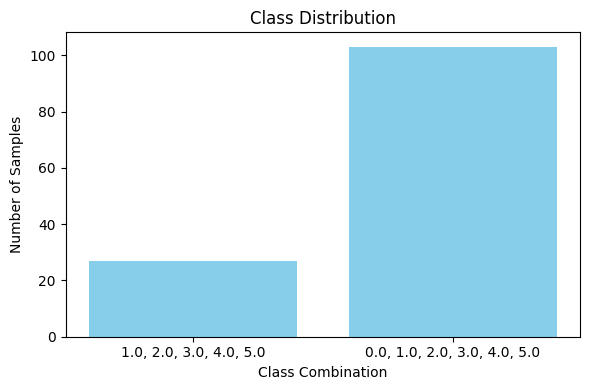

In [10]:
# Show a histogram based on the sample statistic above

# Extract the counts from the stats dictionary
counts = list(stats.values())

# Extract the unique value combinations from the stats dictionary
unique_values_combinations = [', '.join(map(str, key)) for key in stats.keys()]

# Create the histogram
plt.figure(figsize=(6,4))
plt.bar(unique_values_combinations, counts, color='skyblue')
plt.xlabel('Class Combination')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
#plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels for better readability
plt.tight_layout()  # prevent labels from overlapping
plt.show()


In [11]:
# Check unique values in masks and shape of masks
unique_values = np.unique(masks)
print("Unique values in masks:", unique_values)
print("Shape of masks array:", masks.shape)

# Ensure unique values in masks do not exceed the number of classes
n_classes = len(unique_values)
print("Number of classes:", n_classes)

Unique values in masks: [0. 1. 2. 3. 4. 5.]
Shape of masks array: (130, 256, 256, 1)
Number of classes: 6


In [12]:
# Split dataset into train set and validation set
# Determine Number of Unique Classes
masks_cat = to_categorical(masks, num_classes=n_classes)

## Optionally split into train/validation/test sets
x_train, x_val, y_train, y_val = train_test_split(images,
                                                  masks_cat,
                                                  test_size=0.2, # adjust between 0.2 to 0.3
                                                  random_state=42) # adjust but mostly 42

In [13]:
"""
# Split dataset into train set, validation set, and test set
# Determine Number of Unique Classes
masks_cat = to_categorical(masks, num_classes=n_classes)

# Split into train and temporary (val+test) sets
x_train, x_temp, y_train, y_temp = train_test_split(images, masks_cat, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
"""

'\n# Split dataset into train set, validation set, and test set\n# Determine Number of Unique Classes\nmasks_cat = to_categorical(masks, num_classes=n_classes)\n\n# Split into train and temporary (val+test) sets\nx_train, x_temp, y_train, y_temp = train_test_split(images, masks_cat, test_size=0.3, random_state=42)\n\n# Split the temporary set into validation and test sets\nx_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)\n'

## Model Building

### U-Net Architecture

In [14]:
# Function to build U-Net model
def unet_model(input_size=(256, 256, 5), num_classes=6):
    inputs = Input(input_size)

    # Down-sampling path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Up-sampling path
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    output_layer = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[output_layer])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', iou])

    return model

### IoU Metric

In [46]:
# Function to calculate Intersection over Union (IoU)
import tensorflow as tf # Make sure TensorFlow is imported

@tf.function  # Apply tf.function decorator to the entire function
def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), dtype=tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), dtype=tf.float32)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection

    iou_score = (intersection + smooth) / (union + smooth)

    return iou_score

# Wrap the iou function using tf.keras.metrics.MeanIoU
# This allows Keras to serialize and deserialize it correctly
def iou_metric(num_classes=6):  # Adjust num_classes if needed
    return tf.keras.metrics.MeanIoU(num_classes=num_classes)

### Model Plot

In [16]:
# Define dice_loss
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

In [17]:
# Define jaccard_loss
def jaccard_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1)

In [18]:
# Build and compile the model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.00005), # adjust for better result (0.00001 to 0.001), the smaller the better
              loss='categorical_crossentropy',
              #loss=dice_loss,
              #loss=jaccard_loss,
              metrics=['accuracy', iou])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 5)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          2,944 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,380,422 (119.71 MB)

 Trainable params: 31,380,422 (119.71 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [19]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,  # adjust for better result (5, 10,  20), the higher can avoid overfitting
                               restore_best_weights=True)

# Reshape x_train to match the expected input shape of the model
x_train = x_train.transpose(0, 2, 3, 1)  # Change order to (batch_size, height, width, channels)
x_val = x_val.transpose(0, 2, 3, 1)

# Data augmentation for training
datagen = ImageDataGenerator(rotation_range=20,  # adjust for better result (20, 30, 40)
                             width_shift_range=0.1,  # adjust for better result (0.1, 0.2)
                             height_shift_range=0.1,  # adjust for better result (0.1, 0.2)
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=0.2)  # adjust for better result (0.2, 0.3)
datagen.fit(x_train)

# Calculate total training time
# Start timing the training process
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=25, # adjust for better result (20, 30, ..., 100, 200), larger number can lead to better convergence and overfitting, vice versa
                    batch_size=16, # adjust for better result (4, 8, 16, 32, 64), smaller number requires more memory and longer training times, larger number requires more computational resources.
                    callbacks=[early_stopping]
                    )

# End timing the training process
end_time = time.time()

# Collecting IoU values
iou_values = history.history['iou']
val_iou_values = history.history['val_iou']

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (104, 256, 256, 5) (5 channels).
  warnings.warn(


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 219s 24s/step - accuracy: 0.3671 - iou: 0.1265 - loss: 1.5951 - val_accuracy: 0.3827 - val_iou: 0.1657 - val_loss: 1.4191
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 811ms/step - accuracy: 0.3728 - iou: 0.1594 - loss: 1.4665 - val_accuracy: 0.3838 - val_iou: 0.1639 - val_loss: 1.3959
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 856ms/step - accuracy: 0.3837 - iou: 0.1572 - loss: 1.4261 - val_accuracy: 0.3831 - val_iou: 0.1608 - val_loss: 1.3809
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 822ms/step - accuracy: 0.3813 - iou: 0.1596 - loss: 1.3958 - val_accuracy: 0.3866 - val_iou: 0.1682 - val_loss: 1.3494
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 824ms/step - accuracy: 0.3969 - iou: 0.1626 - loss: 1.3769 - val_accuracy: 0.3869 - val_iou: 0.1832 - val_loss: 1.2813
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 826ms/step - accuracy: 0.4181 - iou: 0.1800 - loss: 1.3019 - val_accuracy: 0.3997 - val_iou: 0.1869 - val_loss: 1.2421
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 844ms/step

In [20]:
# Calculate total training time
total_training_time = end_time - start_time

# Convert total training time to minutes and seconds
minutes, seconds = divmod(total_training_time, 60)
print(f'Total training time: {int(minutes)} minutes and {seconds:.2f} seconds')

Total training time: 8 minutes and 16.19 seconds


## Model Evaluation

### Plot Training and Validation

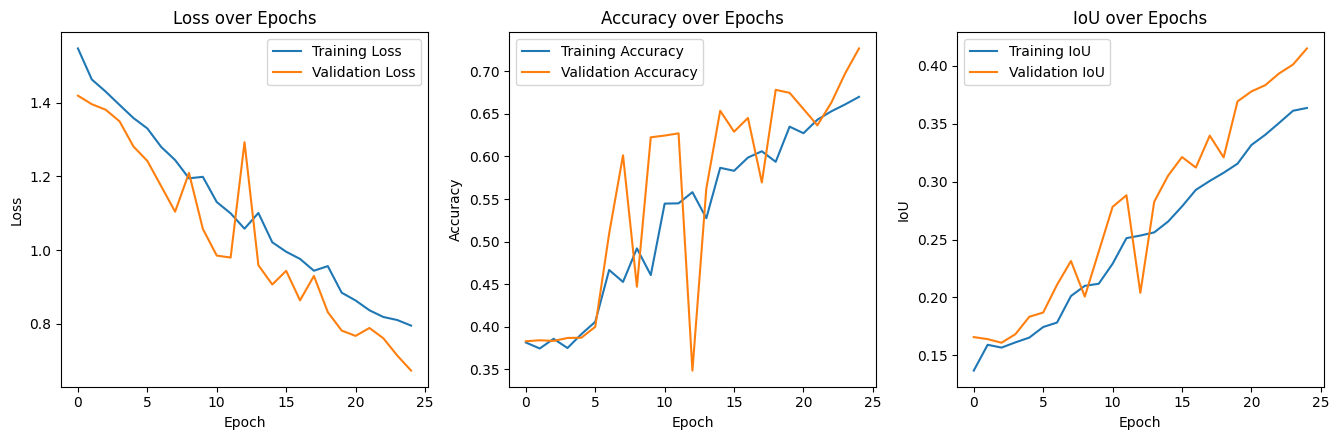

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13.5, 4.5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

ax3.plot(history.history['iou'], label='Training IoU')
ax3.plot(history.history['val_iou'], label='Validation IoU')
ax3.legend()
ax3.set_title('IoU over Epochs')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')

plt.tight_layout()
plt.show()

In [22]:
# Evaluate the model
loss, accuracy, iou_score = model.evaluate(x_val, y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.7271 - iou: 0.4121 - loss: 0.6736


### Show Validation IoU Histogram

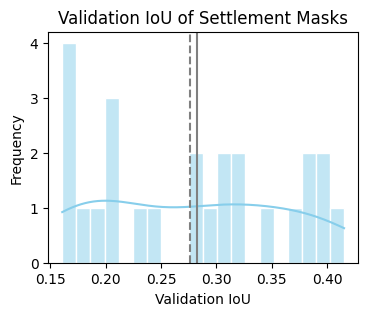

In [23]:
# Calculate mean and median
mean_iou = np.mean(val_iou_values)
median_iou = np.median(val_iou_values)

# Create the histogram of the validation IoU
plt.figure(figsize=(4,3))
#plt.hist(val_iou_values, bins=20, color='skyblue')
sns.histplot(val_iou_values, bins=20, kde=True, color='skyblue', edgecolor='white')

plt.axvline(mean_iou, color='grey', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_iou:.2f}')
plt.axvline(median_iou, color='grey', linestyle='solid', linewidth=1.5, label=f'Median: {median_iou:.2f}')

#plt.legend()
plt.xlabel('Validation IoU')
plt.ylabel('Frequency')
plt.title('Validation IoU of Settlement Masks')
plt.show()

### Evaluate Model Performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


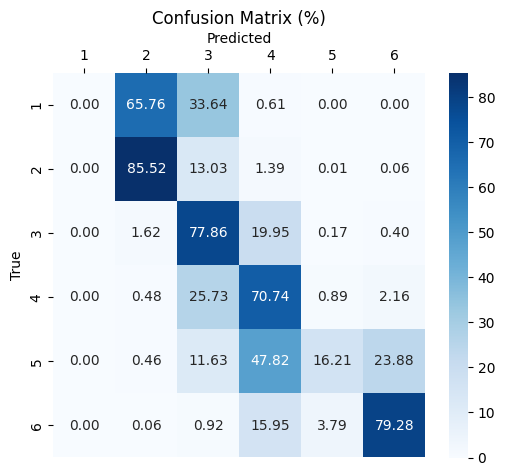

In [24]:
# Generate predictions
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=-1).flatten()
y_true_classes = np.argmax(y_val, axis=-1).flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Convert counts to percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create class labels
class_names = ['1', '2', '3', '4', '5', '6']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (%)')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()

plt.show()

### Save the Model

In [27]:
# Create the directory if it doesn't exist
os.makedirs('drive/MyDrive/Colab Notebooks/AgrAug/model', exist_ok=True)

# Save the model using the native Keras format
model.save('drive/MyDrive/Colab Notebooks/AgrAug/model/overlap50_256.keras')

## Visualisation of Training Results

In [ ]:
# Define the label-to-color mapping
label_to_color = {
    0: (0, 0, 0),        # _background_ - Black
    1: (0, 255, 0),      # formal - Green
    2: (255, 0, 0)       # informal - Red
}

# Function to convert mask to RGB image using label-to-color mapping
def mask_to_rgb(mask):
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for label, color in label_to_color.items():
        rgb_mask[mask == label] = color
    return rgb_mask

# Plot sample predictions with color mapping
def plot_sample_predictions(model, x_val, y_val, image_files, num_images_to_display=5): # Added num_images_to_display parameter
    num_samples = min(len(x_val), num_images_to_display) # Use the minimum to avoid exceeding available samples

    for i in range(num_samples):
        x_sample = x_val[i]
        # Select the first 3 channels of the image
        x_sample_rgb = x_sample[:,:,:3]

        y_true = np.argmax(y_val[i], axis=-1)
        y_pred = np.argmax(model.predict(np.expand_dims(x_sample, axis=0)), axis=-1).squeeze()

        # Get the file name for the current sample
        file_name = image_files[i]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 5))

        ax1.imshow(x_sample_rgb)
        ax1.set_title('True Image')
        ax1.axis('off')

        ax2.imshow(x_sample_rgb)
        ax2.imshow(mask_to_rgb(y_true), alpha=0.5)
        ax2.set_title('True Mask')
        ax2.axis('off')

        ax3.imshow(x_sample_rgb)
        ax3.imshow(mask_to_rgb(y_pred), alpha=0.5)
        ax3.set_title('Predicted Mask')
        ax3.axis('off')

        plt.show()

# Assuming model, x_val, y_val, and image_files are defined
plot_sample_predictions(model, x_val, y_val, image_dir, num_images_to_display=5) # Call with desired number of images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


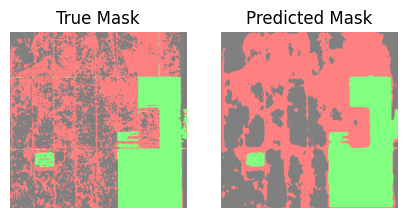

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


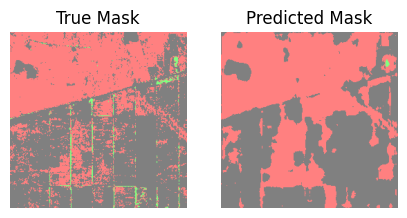

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


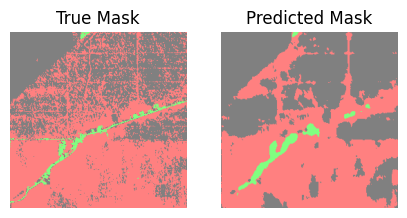

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


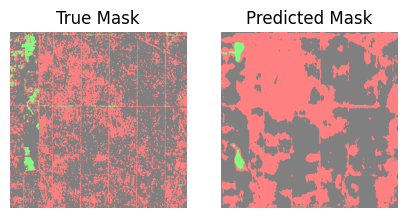

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


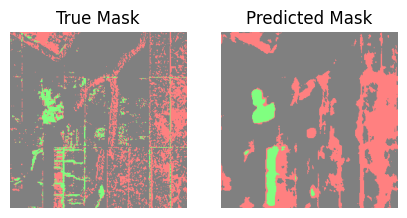

In [43]:
# Define the label-to-color mapping
label_to_color = {
    0: (0, 0, 0),        # _background_ - Black
    1: (0, 255, 0),      # formal - Green
    2: (255, 0, 0)       # informal - Red
}

# Function to convert mask to RGB image using label-to-color mapping
def mask_to_rgb(mask):
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for label, color in label_to_color.items():
        rgb_mask[mask == label] = color
    return rgb_mask

# Plot sample predictions with color mapping
def plot_sample_predictions(model, x_val, y_val, image_files, num_images_to_display=5):
    num_samples = min(len(x_val), num_images_to_display)

    for i in range(num_samples):
        x_sample = x_val[i]
        # Select the first 3 channels of the image
        x_sample_rgb = x_sample[:,:,:3]

        y_true = np.argmax(y_val[i], axis=-1)
        y_pred = np.argmax(model.predict(np.expand_dims(x_sample, axis=0)), axis=-1).squeeze()

        # Get the file name for the current sample
        file_name = image_files[i]

        fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(5, 5)) # Changed to 1 row, 2 columns

        ax2.imshow(x_sample_rgb) # Display the RGB image
        ax2.imshow(mask_to_rgb(y_true), alpha=0.5)
        ax2.set_title('True Mask')
        ax2.axis('off')

        ax3.imshow(x_sample_rgb)
        ax3.imshow(mask_to_rgb(y_pred), alpha=0.5)
        ax3.set_title('Predicted Mask')
        ax3.axis('off')

        plt.show()

# Assuming model, x_val, y_val, and image_files are defined
plot_sample_predictions(model, x_val, y_val, image_dir, num_images_to_display=5)

## Inferencing

In [29]:
# Function to preprocess image
def preprocess_image(image, target_size=(256, 256)):
    # Ensure the image has 3 channels (RGB)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize and normalize the image
    img = image.resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [30]:
# Function to convert mask to RGB image using label-to-color mapping
def mask_to_rgb(mask):
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for label, color in label_to_color.items():
        rgb_mask[mask == label] = color
    return rgb_mask

In [31]:
# Function to patch large image and perform inference
def run_inference_on_large_image(image_path, model, patch_size=256, overlap=64):
    # Load large image
    large_image = Image.open(image_path)
    large_image_width, large_image_height = large_image.size

    # Initialize full-size mask and overlap counter
    mask = np.zeros((large_image_height, large_image_width), dtype=np.float32)
    count = np.zeros((large_image_height, large_image_width), dtype=np.float32)

    stride = patch_size - overlap

    # Iterate over patches
    for top in range(0, large_image_height, stride):
        for left in range(0, large_image_width, stride):
            # Define bottom-right corner
            bottom = min(top + patch_size, large_image_height)
            right = min(left + patch_size, large_image_width)

            # Extract patch
            patch = large_image.crop((left, top, right, bottom))

            # Preprocess patch
            preprocessed_patch = preprocess_image(patch, target_size=(patch_size, patch_size))

            # Predict the mask for the patch
            predicted_patch = model.predict(preprocessed_patch, verbose=0)

            # Convert predictions to class labels
            predicted_patch = np.argmax(predicted_patch, axis=-1).squeeze()

            # Place the patch back into the full-size mask
            mask[top:bottom, left:right] += predicted_patch[:bottom-top, :right-left]
            count[top:bottom, left:right] += 1

    # Normalize mask to handle overlap
    mask /= count
    mask = np.round(mask).astype(np.uint8)

    return mask

In [ ]:
# Load the trained model
model = load_model('drive/MyDrive/Colab Notebooks/AgrAug/model/overlap50_256.keras',
                   custom_objects={'iou': iou})

In [ ]:
# Load the trained model using iou_metric as the custom object
model = load_model('drive/MyDrive/Colab Notebooks/AgrAug/model/overlap50_256.keras',
                    custom_objects={'iou': iou_metric()})  # Use iou_metric() here

### Single Image

In [33]:
# Function to visualise the results
def visualise_results(image_path, mask):
    large_image = Image.open(image_path)
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(large_image)
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(large_image)
    plt.imshow(mask_to_rgb(mask), alpha=0.5)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [ ]:
# Process one large image
image_path = 'drive/MyDrive/Colab Notebooks/AgrAug/432_aoi.tif'

mask = run_inference_on_large_image(image_path, model)

visualise_results(image_path, mask)

# Lab Experiments
